<a href="https://colab.research.google.com/github/CuriousCaliBoi/AgniKai/blob/main/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

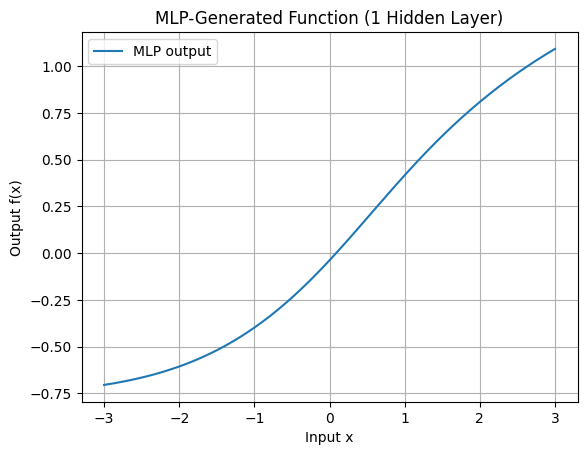

In [1]:
# Install PyTorch (if not already available in your Colab session)
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Define a simple MLP with 1 hidden layer of 5 neurons
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 5),  # Input to hidden
            nn.Tanh(),        # Try ReLU too!
            nn.Linear(5, 1)   # Hidden to output
        )

    def forward(self, x):
        return self.net(x)

# Create the model and disable gradient tracking (inference only)
mlp = SimpleMLP()
mlp.eval()

# Generate 1D inputs from -3 to 3
x = torch.linspace(-3, 3, 300).unsqueeze(1)
with torch.no_grad():
    y = mlp(x)

# Plot the resulting function
plt.plot(x.numpy(), y.numpy(), label="MLP output")
plt.title("MLP-Generated Function (1 Hidden Layer)")
plt.xlabel("Input x")
plt.ylabel("Output f(x)")
plt.grid(True)
plt.legend()
plt.show()

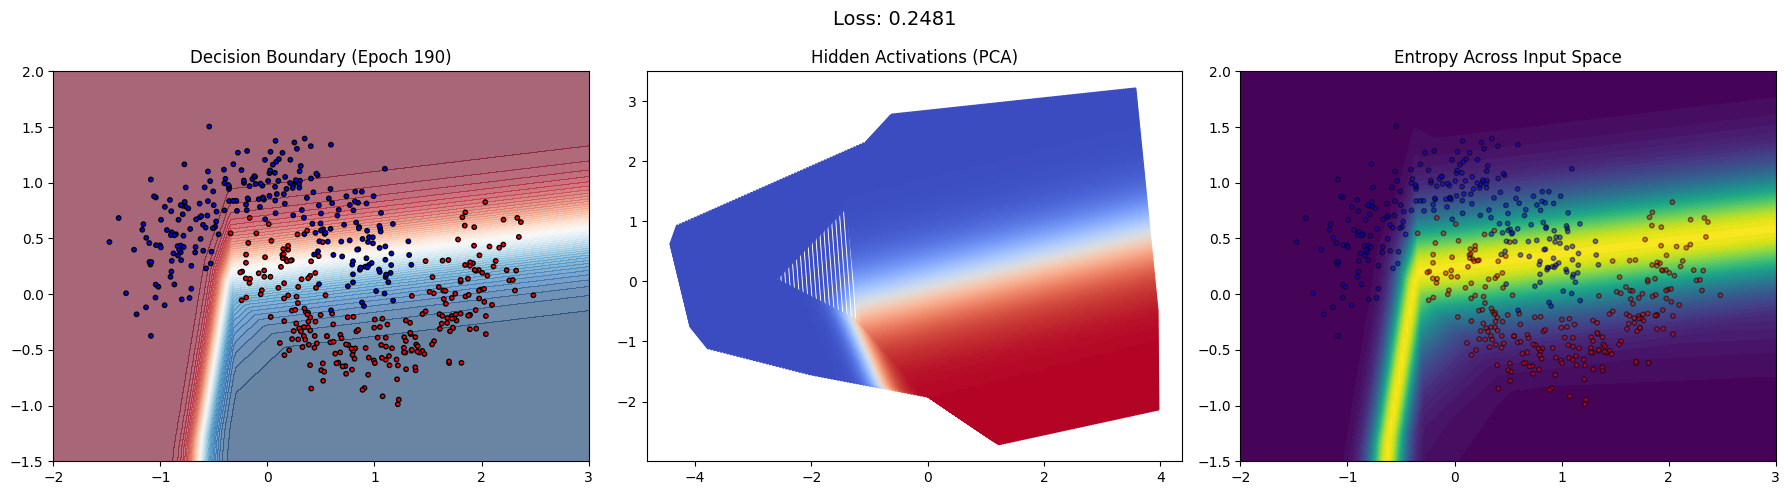

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Generate 2D toy dataset
X, y = make_moons(n_samples=500, noise=0.2, random_state=42)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define tiny neural net
class TinyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 4)
        self.fc2 = nn.Linear(4, 2)

    def forward(self, x):
        z1 = self.fc1(x)
        a1 = F.relu(z1)
        z2 = self.fc2(a1)
        return z2, z1, a1

# Initialize model, optimizer, loss
model = TinyNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
loss_fn = nn.CrossEntropyLoss()

# Grid over input space
xx, yy = torch.meshgrid(torch.linspace(-2, 3, 200), torch.linspace(-1.5, 2, 200), indexing='ij')
grid = torch.stack([xx.flatten(), yy.flatten()], dim=1)

# Track evolution of the model
snapshots = []

for epoch in range(200):
    logits, _, _ = model(X_train)
    loss = loss_fn(logits, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Save state every 10 epochs
    if epoch % 10 == 0:
        with torch.no_grad():
            grid_logits, z1g, a1g = model(grid)
            grid_probs = F.softmax(grid_logits, dim=1)
            grid_entropy = -torch.sum(grid_probs * torch.log(grid_probs + 1e-8), dim=1)
            snapshots.append({
                "epoch": epoch,
                "probs": grid_probs.clone(),
                "entropy": grid_entropy.clone(),
                "hidden": a1g.clone(),
                "loss": loss.item()
            })

# Function to visualize snapshot
def plot_snapshot(snapshot):
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    Z = snapshot["probs"][:, 1].reshape(xx.shape)
    E = snapshot["entropy"].reshape(xx.shape)
    A = snapshot["hidden"].numpy()

    axs[0].contourf(xx, yy, Z.numpy(), levels=50, cmap="RdBu", alpha=0.6)
    axs[0].scatter(X[:,0], X[:,1], c=y, cmap="bwr", edgecolor="k", s=10)
    axs[0].set_title(f"Decision Boundary (Epoch {snapshot['epoch']})")

    proj = PCA(n_components=2).fit_transform(A)
    axs[1].scatter(proj[:,0], proj[:,1], c=Z.flatten().numpy(), cmap="coolwarm", s=2)
    axs[1].set_title("Hidden Activations (PCA)")

    axs[2].contourf(xx, yy, E.numpy(), levels=50, cmap="viridis")
    axs[2].scatter(X[:,0], X[:,1], c=y, cmap="bwr", edgecolor="k", alpha=0.5, s=10)
    axs[2].set_title("Entropy Across Input Space")

    plt.suptitle(f"Loss: {snapshot['loss']:.4f}", fontsize=14)
    plt.tight_layout()
    plt.show()

# Example: visualize final snapshot
plot_snapshot(snapshots[-1])